In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
 df= pd.read_csv('database/extra/data_NLP.csv', index_col='idx')

In [3]:
df.shape

(91669, 3)

In [4]:
df.head()

,Pri_Problem,Synopsis,Narrative
idx,,,
1,Human Factors,SMA PENETRATED TCA ON CLIMB OUT.,THIS WAS MY FIRST DEP FROM BFI ON 31L. MY TURN...
2,Human Factors,SMT PLT DESCENDED TO ARPT UNDERLYING TCA; ACCU...,A VFR FLT; BEING CONDUCTED UNDER FAR PART 91; ...
6,Human Factors,LESS THAN STANDARD SEPARATION BETWEEN TWO ACR ...,ACR Y CLIMBING TO FL210 WAS STOPPED AT 160 FOR...
7,Human Factors,ACR LTT LANDED AT THE WRONG ARPT; DESTINATION ...,SOME TIME HAD PASSED AFTER WE HAD PASSED THE R...
8,Human Factors,LESS THAN STANDARD SEPARATION BETWEEN FLT OF 2...,ACFT X ON FINAL FOR RWY 30L (FLT OF 2) MISSED ...


In [5]:
df.Pri_Problem.unique()

array(['Human Factors', 'Ambiguous', 'Weather', 'Airport', 'None',
       'ATC Equipment / Nav Facility / Buildings', 'Aircraft',
       'Chart Or Publication', 'Company Policy',
       'Environment - Non Weather Related', 'Airspace Structure',
       'Procedure', 'Manuals', 'Equipment / Tooling', 'Staffing', 'MEL',
       'Logbook Entry', 'Incorrect / Not Installed / Unavailable Part'],
      dtype=object)

In [6]:
df=df[~(df.Pri_Problem=='None')]

In [7]:
df.shape

(88071, 3)

In [8]:
prefix=df.Pri_Problem.unique()

In [9]:
df.Pri_Problem.unique()

array(['Human Factors', 'Ambiguous', 'Weather', 'Airport',
       'ATC Equipment / Nav Facility / Buildings', 'Aircraft',
       'Chart Or Publication', 'Company Policy',
       'Environment - Non Weather Related', 'Airspace Structure',
       'Procedure', 'Manuals', 'Equipment / Tooling', 'Staffing', 'MEL',
       'Logbook Entry', 'Incorrect / Not Installed / Unavailable Part'],
      dtype=object)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def make_xy(df, category, vectorizer=None):     
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.Synopsis)
    X = X.tocsc()  
    y = (df.Pri_Problem == category).values.astype(np.int)
    return X, y

In [11]:
df_HF=df.copy()
df_ambiguous=df.copy()
df_weather=df.copy()
df_airport=df.copy()
df_atc=df.copy()
df_aircraft=df.copy()
df_publication=df.copy()
df_company=df.copy()
df_environment=df.copy()
df_airspace=df.copy()

In [12]:
make_xy(df_HF, 'Human Factors')

(<88071x22960 sparse matrix of type '<class 'numpy.int64'>'
 	with 1647331 stored elements in Compressed Sparse Column format>,
 array([1, 1, 1, ..., 0, 0, 0]))

# Human Factors - MNB

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X, y = make_xy(df_HF, 'Human Factors')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
model=Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

Accuracy Scores for the Training set : 0.8058524874693831  and Test Set : 0.79218075845886
True


In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[ 3947  2239]
 [ 3252 16984]]


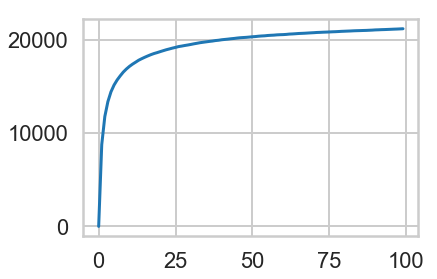

In [20]:
m, n = X.shape
sX = X.toarray().sum(axis=0)


sY = [np.sum(sX <= x) for x in range(m)]
ax = plt.plot(sY[:100])

In [21]:
from sklearn.model_selection import KFold
def cv_score(df, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        df.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(df, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

def log_likelihood(df, x, y):
    prob = df.predict_log_proba(x)
    not_reason = y == 0
    reason = ~not_reason
    return prob[not_reason, 0].sum() + prob[reason, 1].sum()

In [23]:
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for (alpha,min_df) in zip(alphas,min_dfs):        
    vectorizer = CountVectorizer(min_df=min_df)       
    Xthis, ythis = make_xy(df_HF, 'Human Factors')
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
   
    mod = MultinomialNB(alpha=alpha)
    score = cv_score(mod, Xtrainthis, ytrainthis, log_likelihood)
    if score > maxscore:
        maxscore = score
        best_alpha, best_min_df = alpha, min_df
        
print("alpha: {}".format(best_alpha))

print ("min_df: {}".format(best_min_df))

alpha: 1
min_df: 0.0001


In [22]:
#from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(df_HF.shape[0]), train_size=0.7)
mask = np.zeros(df_HF.shape[0], dtype=np.bool)
mask[itest] = True

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Human Factors - TFIDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(min_df = best_min_df, stop_words = "english")
vectorizer = CountVectorizer(min_df=best_min_df)
x, y = make_xy(df_HF, 'Human Factors', tfidfvectorizer)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

mod = MultinomialNB(alpha = best_alpha).fit(x_train, y_train)

training_accuracy = mod.score(x_train, y_train)
test_accuracy = mod.score(x_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.805852
Accuracy on test data:     0.792181


# Ambiguous - MNB

In [25]:
X, y = make_xy(df_weather, 'Ambiguous')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.916073253418547  and Test Set : 0.8995155552191356
True
[[23434  1418]
 [ 1237   333]]


# Weather - MNB

In [26]:
X, y = make_xy(df_ambiguous, 'Weather')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.9714026180473325  and Test Set : 0.9678676860192263
True
[[25167   365]
 [  484   406]]


# Airport - MNB

In [27]:
X, y = make_xy(df_airport, 'Airport')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.9906730036172525  and Test Set : 0.9902354098857014
True
[[26156    50]
 [  208     8]]


# ATC Equipment / Nav Facility / Buildings - MNB

In [28]:
X, y = make_xy(df_atc, 'ATC Equipment / Nav Facility / Buildings')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.9905756784376064  and Test Set : 0.9892892286730754
True
[[26090    47]
 [  236    49]]


# Aircraft - MNB

In [29]:
X, y = make_xy(df_aircraft, 'Aircraft')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.9830491978783111  and Test Set : 0.9802437362803724
True
[[25896    97]
 [  425     4]]


# Chart Or Publication - MNB

In [ ]:
X, y = make_xy(df_publication, 'Chart Or Publication')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

# Company Policy - MNB

In [36]:
X, y = make_xy(df_company, 'Company Policy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.9509805511849341  and Test Set : 0.9458784346378019
True
[[24521  1124]
 [  306   471]]


# Environment - Non Weather Related - MNB

In [37]:
X, y = make_xy(df_environment, 'Environment - Non Weather Related')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.9936414215964574  and Test Set : 0.9929982590265688
True
[[26237    22]
 [  163     0]]


# Airspace Structure - MNB

In [38]:
X, y = make_xy(df_airspace, 'Airspace Structure')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

Accuracy Scores for the Training set : 0.989797077000438  and Test Set : 0.9885322837029747
True
[[26118    40]
 [  263     1]]


# TOP 3 Classification

In [13]:
top3=['Human Factors', 'Ambiguous','Procedure']
df_top3=df[df.Pri_Problem.isin(top3)]

In [14]:
df_top3.shape

(76692, 3)

In [15]:
df_top3.head()

,Pri_Problem,Synopsis,Narrative
idx,,,
1,Human Factors,SMA PENETRATED TCA ON CLIMB OUT.,THIS WAS MY FIRST DEP FROM BFI ON 31L. MY TURN...
2,Human Factors,SMT PLT DESCENDED TO ARPT UNDERLYING TCA; ACCU...,A VFR FLT; BEING CONDUCTED UNDER FAR PART 91; ...
6,Human Factors,LESS THAN STANDARD SEPARATION BETWEEN TWO ACR ...,ACR Y CLIMBING TO FL210 WAS STOPPED AT 160 FOR...
7,Human Factors,ACR LTT LANDED AT THE WRONG ARPT; DESTINATION ...,SOME TIME HAD PASSED AFTER WE HAD PASSED THE R...
8,Human Factors,LESS THAN STANDARD SEPARATION BETWEEN FLT OF 2...,ACFT X ON FINAL FOR RWY 30L (FLT OF 2) MISSED ...


In [16]:
df_top3.Pri_Problem.unique()

array(['Human Factors', 'Ambiguous', 'Procedure'], dtype=object)

# MNB

In [39]:
X=vectorizer.fit_transform(df_top3.Synopsis)
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

Mul_NB = MultinomialNB()
Mul_NB.fit(X_train, y_train)

TrainingAccuracy = Mul_NB.score(X_train,y_train)

y_pred = Mul_NB.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = Mul_NB.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

print()
print("Classification Report")
print(classification_report(y_test, y_pred))


Accuracy Scores for the Training set : 0.8250689218389091  and Test Set : 0.8140212100139083
True
[[  467   862   253]
 [ 1427 17276  1502]
 [  217    18   986]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.22      0.30      0.25      1582
Human Factors       0.95      0.86      0.90     20205
    Procedure       0.36      0.81      0.50      1221

    micro avg       0.81      0.81      0.81     23008
    macro avg       0.51      0.65      0.55     23008
 weighted avg       0.87      0.81      0.83     23008



# TFIDF  


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df_top3.Synopsis)
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf = MultinomialNB().fit(X_train, y_train)

TrainingAccuracy = clf.score(X_train,y_train)

y_pred = clf.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = clf.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Scores for the Training set : 0.8832054243349974  and Test Set : 0.8786509040333796
True
[[    2  1577     6]
 [    6 20143    34]
 [    2  1167    71]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.20      0.00      0.00      1585
Human Factors       0.88      1.00      0.94     20183
    Procedure       0.64      0.06      0.11      1240

    micro avg       0.88      0.88      0.88     23008
    macro avg       0.57      0.35      0.35     23008
 weighted avg       0.82      0.88      0.83     23008



# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

X=vectorizer.fit_transform(df_top3.Synopsis)
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)


log = LogisticRegression().fit(X_train, y_train)

TrainingAccuracy = log.score(X_train,y_train)

y_pred = log.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = log.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

print()
print("Classification Report")
print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Scores for the Training set : 0.9219506743163699  and Test Set : 0.885778859527121
True
[[  207  1287    91]
 [  250 19642   291]
 [  112   597   531]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.36      0.13      0.19      1585
Human Factors       0.91      0.97      0.94     20183
    Procedure       0.58      0.43      0.49      1240

    micro avg       0.89      0.89      0.89     23008
    macro avg       0.62      0.51      0.54     23008
 weighted avg       0.86      0.89      0.87     23008



# Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

X=vectorizer.fit_transform(df_top3.Synopsis)
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf = clf.fit(X_train,y_train)

TrainingAccuracy = clf.score(X_train,y_train)

y_pred = clf.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = clf.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Scores for the Training set : 0.8861113180836003  and Test Set : 0.882519123783032
True
[[   24  1535    26]
 [   13 19978   192]
 [   26   911   303]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.38      0.02      0.03      1585
Human Factors       0.89      0.99      0.94     20183
    Procedure       0.58      0.24      0.34      1240

    micro avg       0.88      0.88      0.88     23008
    macro avg       0.62      0.42      0.44     23008
 weighted avg       0.84      0.88      0.84     23008



# Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

X=vectorizer.fit_transform(df_top3.Synopsis)
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

TrainingAccuracy = clf.score(X_train,y_train)

y_pred = clf.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = clf.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Scores for the Training set : 0.9988637210342002  and Test Set : 0.8858657858136301
True
[[   33  1549     3]
 [   16 20105    62]
 [   17   979   244]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.50      0.02      0.04      1585
Human Factors       0.89      1.00      0.94     20183
    Procedure       0.79      0.20      0.32      1240

    micro avg       0.89      0.89      0.89     23008
    macro avg       0.73      0.40      0.43     23008
 weighted avg       0.86      0.89      0.84     23008



# Tuning with Random forest

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def evaluate(grid_search, clf, Xtrain, Xtest, ytrain, ytest):
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:2f}".format(training_accuracy))
    print("Accuracy on test data:     {:2f}".format(test_accuracy))

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print()
    print("Classification Report")
    print(classification_report(ytest, clf.predict(Xtest)))

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('gbm', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
])

parameters = {
    'vect__ngram_range': [(1,1), (1, 2)],
    #'gbm__n_estimators': [100,200,300],
    #'gbm__max_depth': [15,30,None],
    #'gbm__max_features': ['sqrt','log2'],
    'rfc__n_estimators': [100,200,300],
    'rfc__max_depth': [15,30,None],
    'rfc__max_features': ['sqrt','log2'],
    'rfc__class_weight': ['balanced', None]    
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)

X=df_top3.Synopsis
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf = grid_search.fit(X_train, y_train)
evaluate(grid_search, clf, X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best score: 0.885
Best parameters set:
	rfc__class_weight: None
	rfc__max_depth: None
	rfc__max_features: 'sqrt'
	rfc__n_estimators: 200
	vect__ngram_range: (1, 1)
Accuracy on training data: 0.998864
Accuracy on test data:     0.883736
[[   26  1557     2]
 [   11 20128    44]
 [   15  1046   179]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.50      0.02      0.03      1585
Human Factors       0.89      1.00      0.94     20183
    Procedure       0.80      0.14      0.24      1240

    micro avg       0.88      0.88      0.88     23008
    macro avg       0.73      0.39      0.40     23008
 weighted avg       0.85      0.88      0.84     23008



# GBM

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

X=vectorizer.fit_transform(df_top3.Synopsis)
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
    
TrainingAccuracy = gb.score(X_train,y_train)

y_pred = gb.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = gb.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Scores for the Training set : 0.8949221369495567  and Test Set : 0.8867350486787204
True
[[   80  1483    22]
 [   55 19939   189]
 [   45   812   383]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.44      0.05      0.09      1585
Human Factors       0.90      0.99      0.94     20183
    Procedure       0.64      0.31      0.42      1240

    micro avg       0.89      0.89      0.89     23008
    macro avg       0.66      0.45      0.48     23008
 weighted avg       0.85      0.89      0.85     23008



# Tuning with GBM

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def evaluate(grid_search, clf, Xtrain, Xtest, ytrain, ytest):
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:2f}".format(training_accuracy))
    print("Accuracy on test data:     {:2f}".format(test_accuracy))

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print()
    print("Classification Report")
    print(classification_report(ytest, clf.predict(Xtest)))

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('gbm', GradientBoostingClassifier()),
    #('rfc', RandomForestClassifier()),
])

parameters = {
    'vect__ngram_range': [(1,1), (1, 2)],
    'gbm__n_estimators': [100,200,300],
    'gbm__max_depth': [15,30,None],
    'gbm__max_features': ['sqrt','log2'],
    #'rfc__n_estimators': [100,200,300],
    #'rfc__max_depth': [15,30,None],
    #'rfc__max_features': ['sqrt','log2'],
    #'rfc__class_weight': ['balanced', None]    
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)

X=df_top3.Synopsis
y=df_top3.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf = grid_search.fit(X_train, y_train)
evaluate(grid_search, clf, X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best score: 0.890
Best parameters set:
	gbm__max_depth: 30
	gbm__max_features: 'sqrt'
	gbm__n_estimators: 200
	vect__ngram_range: (1, 2)
Accuracy on training data: 0.968873
Accuracy on test data:     0.887170
[[   81  1474    30]
 [   51 19960   172]
 [   39   830   371]]

Classification Report
               precision    recall  f1-score   support

    Ambiguous       0.47      0.05      0.09      1585
Human Factors       0.90      0.99      0.94     20183
    Procedure       0.65      0.30      0.41      1240

    micro avg       0.89      0.89      0.89     23008
    macro avg       0.67      0.45      0.48     23008
 weighted avg       0.85      0.89      0.85     23008



# Top 6 Classification

In [32]:
top6=['Human Factors', 'Ambiguous','Procedure','Weather', 'Company Policy', 'Aircraft']
df_top6=df[df.Pri_Problem.isin(top6)]

# Random Forest Top 6

In [45]:
from sklearn.ensemble import RandomForestClassifier

X=vectorizer.fit_transform(df_top6.Synopsis)
y=df_top6.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

TrainingAccuracy = clf.score(X_train,y_train)

y_pred = clf.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = clf.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Scores for the Training set : 0.9980547070969064  and Test Set : 0.8213887561713649
True
[[   13     1     0   411     7     2]
 [    2    34     3  1523     3     7]
 [    0     0    59   722    19     1]
 [   16    19    10 20020    44    47]
 [    0    15     1   968   264     1]
 [    1     0     1   642    20   240]]

Classification Report
                precision    recall  f1-score   support

      Aircraft       0.41      0.03      0.06       434
     Ambiguous       0.49      0.02      0.04      1572
Company Policy       0.80      0.07      0.13       801
 Human Factors       0.82      0.99      0.90     20156
     Procedure       0.74      0.21      0.33      1249
       Weather       0.81      0.27      0.40       904

     micro avg       0.82      0.82      0.82     25116
     macro avg       0.68      0.27      0.31     25116
  weighted avg       0.79      0.82      0.76     25116



# GBM Top 6 

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

X=vectorizer.fit_transform(df_top6.Synopsis)
y=df_top6.Pri_Problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
    
TrainingAccuracy = gb.score(X_train,y_train)

y_pred = gb.predict(X_test)

TestAccuracy = accuracy_score(y_test, y_pred)
ttacc = gb.score(X_test,y_test)

print('Accuracy Scores for the Training set : {0}  and Test Set : {1}'.format(TrainingAccuracy, 
                                                                                         TestAccuracy))
print(ttacc==TestAccuracy)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Scores for the Training set : 0.8385406890432231  and Test Set : 0.8219461697722568
True
[[   19     2     2   393    14     4]
 [    1    54    31  1423    28    35]
 [    3     4   107   656    28     3]
 [   19    34    51 19794   161    97]
 [    1    29    18   829   366     6]
 [    3     1     3   560    33   304]]

Classification Report
                precision    recall  f1-score   support

      Aircraft       0.41      0.04      0.08       434
     Ambiguous       0.44      0.03      0.06      1572
Company Policy       0.50      0.13      0.21       801
 Human Factors       0.84      0.98      0.90     20156
     Procedure       0.58      0.29      0.39      1249
       Weather       0.68      0.34      0.45       904

     micro avg       0.82      0.82      0.82     25116
     macro avg       0.57      0.30      0.35     25116
  weighted avg       0.78      0.82      0.77     25116

